# 4팀: 교보문고 연간 베스트 데이터 분석하기
### - 연간 베스트 5개년 데이터

### 살펴 볼 질문

- 5개년 간 상위를 차지한 장르는?
- 위의 장르가 5개년 간 순위 리스트에서 차지한 비율은?
- 각 장르별 많이 달린 코멘트의 유형은? (ex> "고마워요", "유익해요" etc.)
- 도서별 장당 가격과, 장당 가격이 전체 순위에 미치는 영향은? [장르별 비교]

## 0. 모듈 설치하기

In [51]:
# 파이썬 라이브러리
import requests
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
# elem.send_keys(Keys.ENTER)
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import re
import time
from datetime import datetime

import pymysql # mysql 연결및 실행을 위한 모듈
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt #차트 처리를 위한 모듈
%matplotlib inline
import matplotlib.font_manager as fm
from wordcloud import WordCloud
from PIL import *
import seaborn as sns
from IPython.display import Image

In [53]:
from PIL import *

## 1.  웹 스크래핑 - 교보문고 연간 베스트 5개년(2018~2022)
### 1.1 베스트 도서들 링크 불러오기

In [2]:
# 교보문고 연간 베스트셀러 100권(2018-2022 5년간) url 스크래핑

user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'

years = [i for i in range(2018,2023)]
urls = []
for year in years: # 2018-2022 5년간 반복
    urls.append([])
    for i in range(1,6): # 한 페이지 당 20권, 5페이지 반복
        # 연간 베스트렐러 목록 페이지 불러오기
        url = 'https://product.kyobobook.co.kr/bestseller/total?period=004#?page=%d&per=20&period=004&ymw=%d&bsslBksClstCode=A'%(i,year)

        options = webdriver.ChromeOptions()
        options.add_argument(user_agent)
        # 페이지 안 열기
        options.add_argument('headless') 
        options.add_argument('window-size=1920x1080')#사이즈지정
        options.add_argument("disable-gpu")#안보이게
        # 혹은 options.add_argument("--disable-gpu")
        #페이지 안열기_
        driver = webdriver.Chrome(options=options)
        driver.implicitly_wait(2)
        driver.get(url)
        time.sleep(1)

        # 각 책의 url 뽑아 urls list에 저장
        elems = driver.find_elements_by_class_name('prod_link')
        for j in range(20):
            urls[-1].append(elems[j].get_attribute('href'))

# year_urls 딕셔너리, 키는 연도, 값은 연간베스트도서 url 100개짜리 리스트
year_urls = dict(zip(years,urls))

2022 done
2022 done
2022 done
2022 done
2022 done


### 1.2 SQL 연결- 도서 정보 테이블 만들기

In [ ]:
# sql 연결 및 best_books_5years 테이블 생성
db = pymysql.connect(host='localhost', port=3306, user='root', passwd='1234', db='mywork', charset='utf8')
cursor = db.cursor()
sql = """
    CREATE TABLE IF NOT EXISTS best_books_5years(
        years SMALLINT NOT NULL,
        ranks SMALLINT NOT NULL,
        title VARCHAR(100),
        author VARCHAR(100),
        publisher VARCHAR(100),
        publishdate DATE,
        price INT,
        rate DOUBLE,
        likes VARCHAR(50),
        review_n INT,
        genre VARCHAR(50),
        page INT);"""
cursor.execute(sql)

### 1.3 테이블 채우기

- 상세 페이지 들어가 세부 정보 가져오기

In [ ]:
# 테이블 채우기
for key, value in year_urls.items():
    # years <- key
    for i in range(len(value)):
        # ranks <- i+1
        
        headers = {'User-Agent':user_agent}
        response = requests.get(value[i], headers) # value[i]가 각 도서링크
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'lxml')
        
        title = soup.select_one('div.prod_title_area h1').text.replace(' ', '').replace('\n', '')
        # title <- title

        author = soup.select_one('div.author').text.replace(' ', '').replace('\n', '').split('저')
        # author <- author[0]

        #붙어있는 publish 정보 분리해서 사용
        publish_info = soup.select_one('div.prod_info_text.publish_date').text
        publish_info = publish_info.replace(' ', '').replace('\n', '').split('·')
        # publisher <- publish_info[0]
        datetime_format = "%Y년%m월%d일"
        publishdate = datetime.strptime(publish_info[1][:11], datetime_format).date()
        # publishdate <- publishdate

        price = soup.select_one('span.price span.val').text.replace('원', '').replace(',', '')
        # price <- price
        
        rating = soup.select_one('span.review_score.feel_lucky').text
        # rate <- rating

        like = soup.select_one('span.review_quotes_text').text
        # likes <- like

        cnt_review = soup.select_one('span.review_desc span.val').text
        # review_n <- cnt_review
        
        genere = soup.select('ol li.breadcrumb_item a')
        # genre <- genere[2].text
        
        page_link = soup.select('tr>td')
        page=page_link[2].text
        page_num = re.sub(r'[^0-9]', '', page) #'쪽' '준비중' 떼기
        #'준비중' 이라면 (페이지 숫자가 없다면) 0으로 처리하기
        if page_num == '': 
            page_num = page_num.replace('', '0')
        # page <- int(page_num)    
        
        #format 합수 이용해서 테이블에 정보 집어넣기
        sql = '''
        INSERT INTO best_books_5years VALUES(
        {0}, {1}, "{2}", "{3}", "{4}", "{5}", {6}, {7}, "{8}", {9}, "{10}", {11});
        '''.format(key, i+1, title, author[0], publish_info[0], publishdate,
                   int(price), float(rating), like, int(cnt_review), genere[2].text, int(page_num))
        cursor.execute(sql)
#    print(year, 'done') <- 잘 받아지는지 확인용으로 사용
        
db.commit()

![5개년 연간 베스트 테이블](best_books_5y.png)

## 분석 1.1 [상위 5개 장르]
### 연도별 인기 장르 - 워드클라우드로 보기

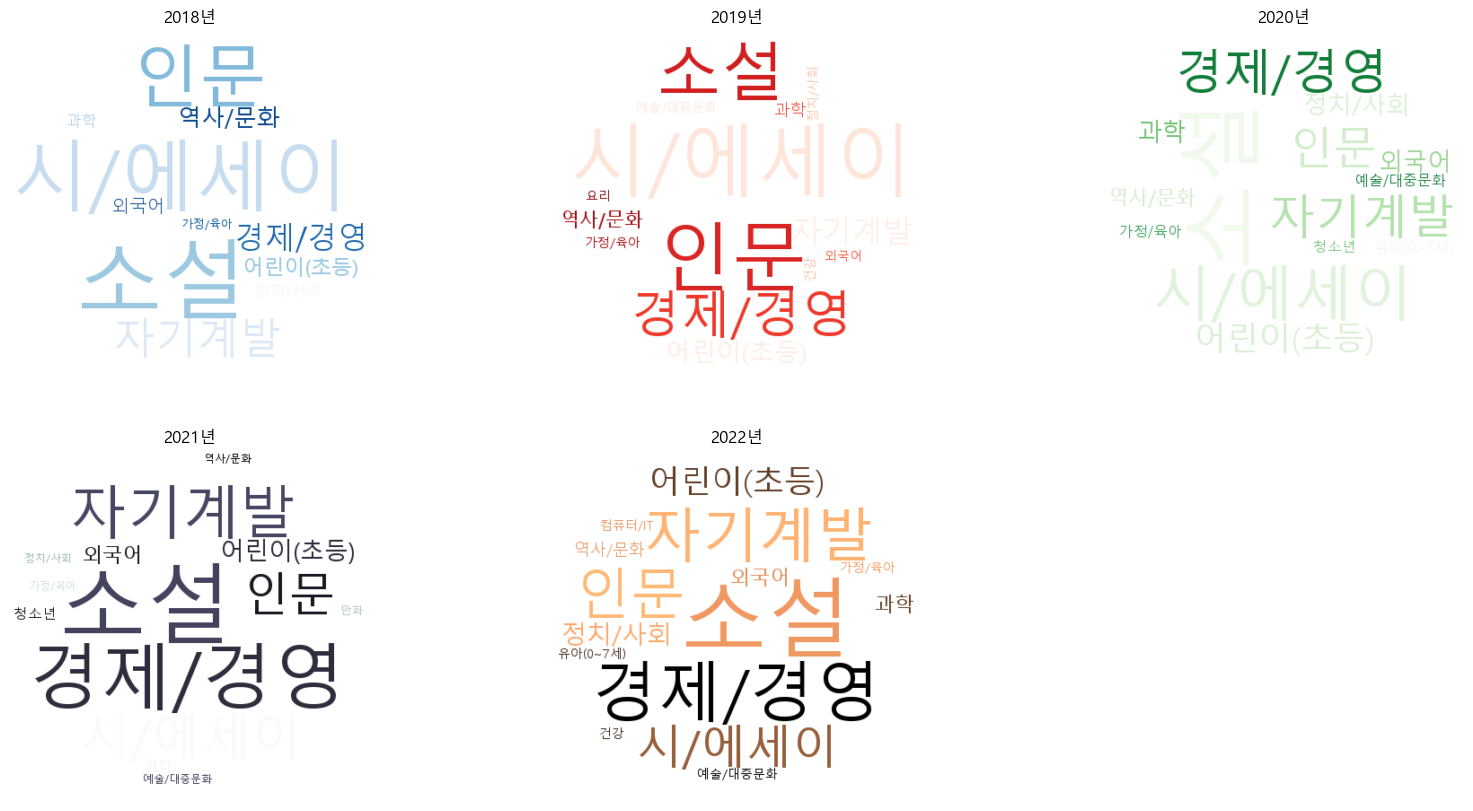

In [60]:
# 워드클라우드 연도별로 출력하기

# 한글 폰트 설정 #깨짐방지
# print([font.name for font in fm.fontManager.ttflist]) # 설치된 폰트 출력
plt.rcParams['font.family'] = 'Malgun Gothic'

# 워드 클라우드 이미지
cand_mask=np.array(Image.open('circle.jpg')) 

# 2018년부터 2022년까지
plt.figure(figsize=(20,10))
years = [i for i in range(2018,2023)]
colors = ['Blues','Reds','Greens','bone','copper']
i = 1

for year in years:  
    SQL = """
    SELECT genre, count(*)
    FROM best_books_5years
    WHERE years = {}
    GROUP BY genre;""".format(year) #  SQL 구문 만들기
    cursor.execute(SQL)
    res = cursor.fetchall()
    dict_res = dict((x,y)for x,y in res) # tuple -> dictionary
    
    # wrodcloud 생성
    wordcloud = WordCloud(font_path='malgun.ttf', background_color='white', 
                          colormap=colors[i-1], mask=cand_mask,).generate_from_frequencies(dict_res)
    plt.subplot(2,3,i)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.title('{}년'.format(year))
    plt.axis('off')
    i+=1
plt.show()

![WorldCloud_5years](wordcloud_5y.png)

## 분석 1.2 [상위 5개 장르]
### 연도별 인기 장르 - 원그래프로 보기 

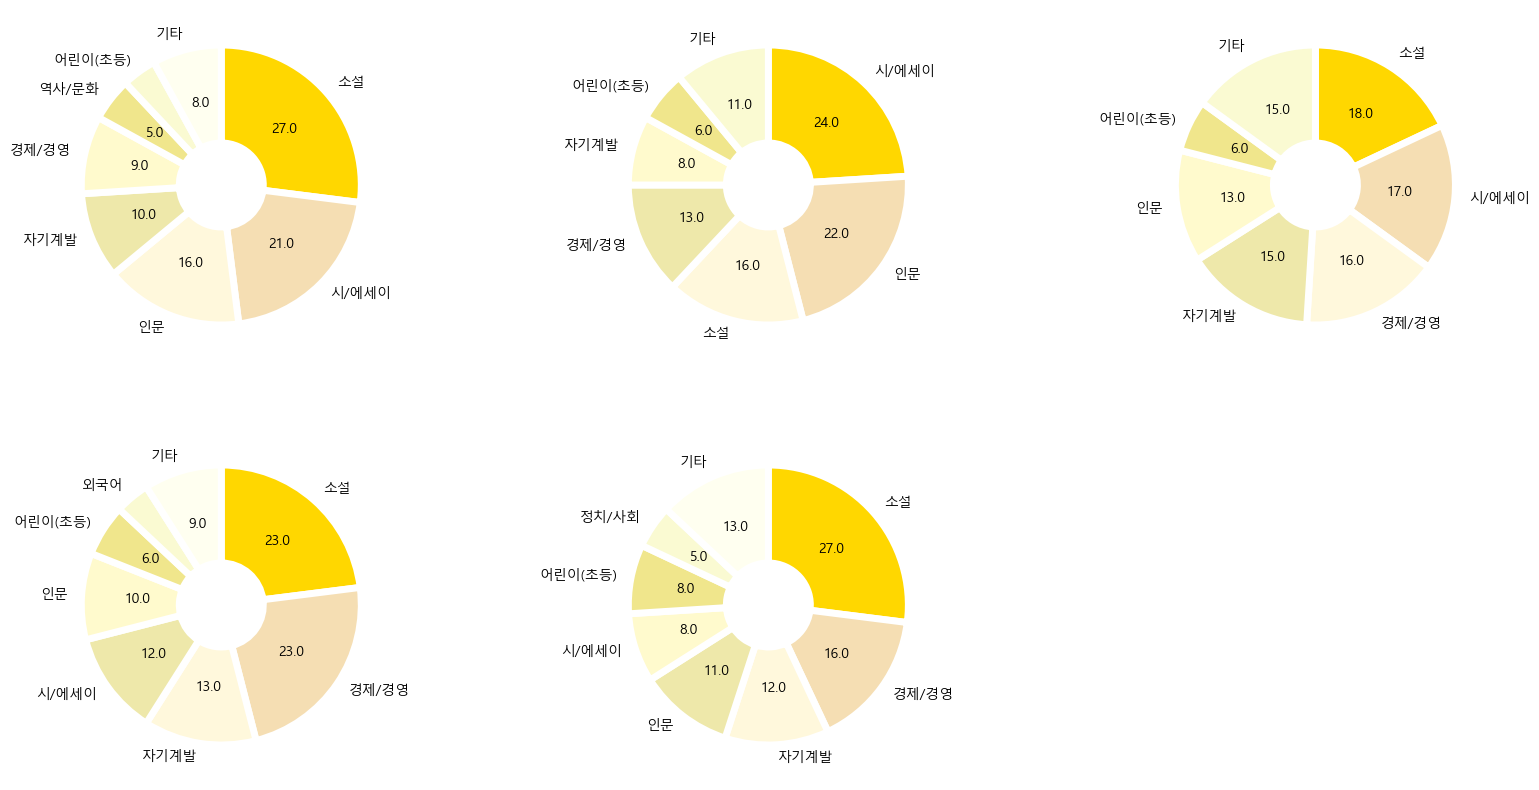

In [59]:
# 원그래프 연도별로 출력하기
plt.figure(figsize=(20,10))
colors = ['gold','wheat','cornsilk','palegoldenrod','lemonchiffon',
         'khaki','lightgoldenrodyellow','ivory']

# 2018년부터 2022년까지
years = [i for i in range(2018, 2023)]
i = 1

for year in years:
    
    SQL = """
    WITH sub AS (
        SELECT genre, count(*) AS c 
        FROM best_books_5years
        WHERE years = {} 
        GROUP BY genre
        ORDER BY 2 DESC
        )
    SELECT * 
    FROM  sub a WHERE a.c > 3
    UNION
    SELECT concat('기타') genre, 
        sum(b.c) AS c 
    FROM sub AS b 
    WHERE b.c <= 3;
    """.format(year)
    
    cursor.execute(SQL)
    res = cursor.fetchall()
    dict_res = dict((x,y)for x,y in res) # # tuple -> dictionary 
    
    # x: labels = 장르, y: ratio = 비율
    ratio = []
    labels = []
    
    for key, value in dict_res.items():
        labels.append(key)
        ratio.append(value)
        
    plt.subplot(2,3,i)
    i+=1
    
    plt.pie(ratio, labels=labels, startangle=90, counterclock=False, 
            autopct=(lambda x: str(round(x,0)) if x > 5 else ' '), 
            colors=colors,wedgeprops={'edgecolor':'w','width':0.7, 'linewidth':5})
    
# 책이 3권 이하는 기타
plt.show()

#### 상위 5개 장르 : 소설, 시/에세이, 인문, 자기계발임을 확인

## 분석 2.1
### 장르별-연도별 베스트 비중 추이 : 꺾은선그래프로 보기

In [30]:
# '경제/경영','소설','시/에세이','인문','자기계발' 상위 5장르의 권 수 꺾은선 그래프

# 딕셔너리 형식으로 sql 분석쿼리 불러오기

cursor = db.cursor(pymysql.cursors.DictCursor) 
sql = """
WITH book18 AS(SELECT genre, count(*) c 
    FROM best_books_5years WHERE years=2018 GROUP BY genre),
 book19 AS(SELECT genre, count(*) c 
    FROM best_books_5years WHERE years=2019 GROUP BY genre),
book20 AS(SELECT genre, count(*) c 
    FROM best_books_5years WHERE years=2020 GROUP BY genre),
book21 AS(SELECT genre, count(*) c 
    FROM best_books_5years WHERE years=2021 GROUP BY genre),
book22 AS(SELECT genre, count(*) c 
    FROM best_books_5years WHERE years=2022 GROUP BY genre)
SELECT g.genre, 
    b18.c AS count18, 
    b19.c AS count19, 
    b20.c AS count20, 
    b21.c AS count21, 
    b22.c AS count22
FROM genre_idx g LEFT JOIN book22 b22 ON g.genre = b22.genre
                 LEFT JOIN book21 b21 ON g.genre = b21.genre
                 LEFT JOIN book20 b20 ON g.genre = b20.genre
                 LEFT JOIN book19 b19 ON g.genre = b19.genre
                 LEFT JOIN book18 b18 ON g.genre = b18.genre
WHERE NOT(b22.c IS NULL and b21.c IS NULL and b20.c IS NULL
      and b19.c IS NULL and b18.c IS NULL)
ORDER BY 2 DESC 
LIMIT 5;"""
cursor.execute(query=sql)
result = cursor.fetchall() #딕셔너리


### 장르별 연도 비중 추이

![결과: 장르별_연도_비중추이](장르별_연도흐름_순위추이.png)

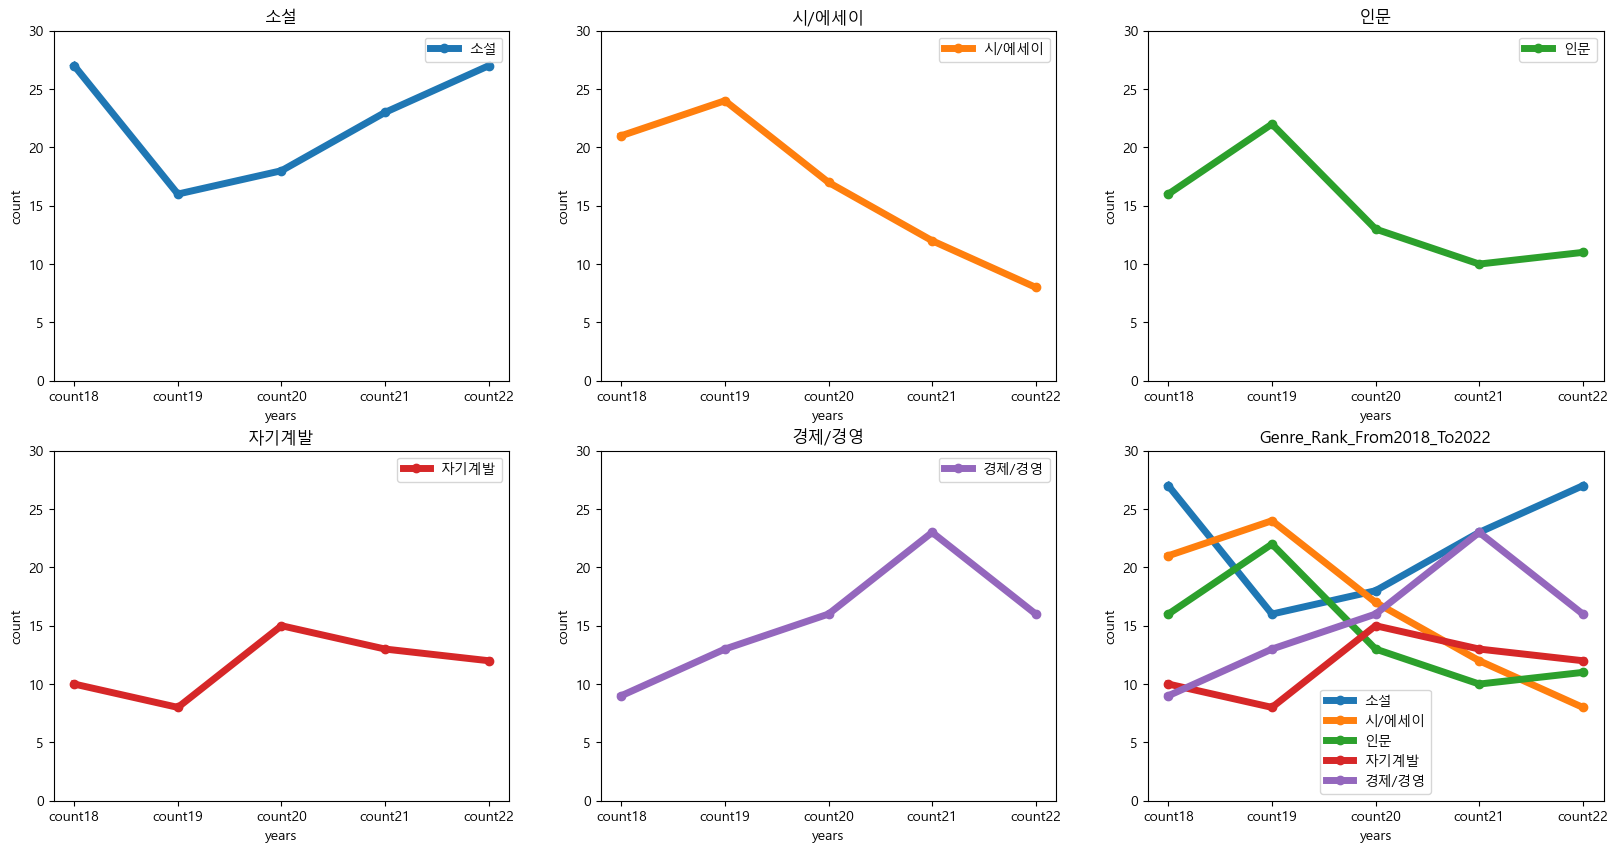

In [32]:
fig = plt.figure(figsize=(20,10))
fig.set_facecolor('white')

# 각 장르별 경향

#x좌표
x = list(result[0].keys()); y = [] #키 =  연도 발류 = 순위
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']



for i in range(len(result)):
    y.append(list(result[i].values()))
    
    #좌표, 2행 3열의 판
    plt.subplot(2,3,i+1) 
    
    #플랏 띄우기,
    plt.plot(x[1:],y[-1][1:],marker='o',label=y[-1][0], linewidth='5',color=colors[i]) 
     #x값: 장르 빼고 (0빼고) 1~끝까지 y값: 장르 빼고 (0빼고) 1~끝까지
    
    #제목: 장르명
    plt.title(y[-1][0]) 
    #y축 고정
    plt.legend(); plt.ylim([0,30]) 
    plt.xlabel('years'); plt.ylabel('count')
    
# 종합 
#6번째 그림
for i in range(len(result)):
    plt.subplot(2,3,6)
    plt.plot(x[1:],y[i][1:],marker='o',label=y[i][0], linewidth='5')
    plt.title('Genre_Rank_From2018_To2022')
    plt.xlabel('years'); plt.ylabel('count')

plt.legend() #종합의 레전드
plt.ylim([0,30])
plt.show()

## 분석 2.1.2 
### 종합 그래프 크게 보기

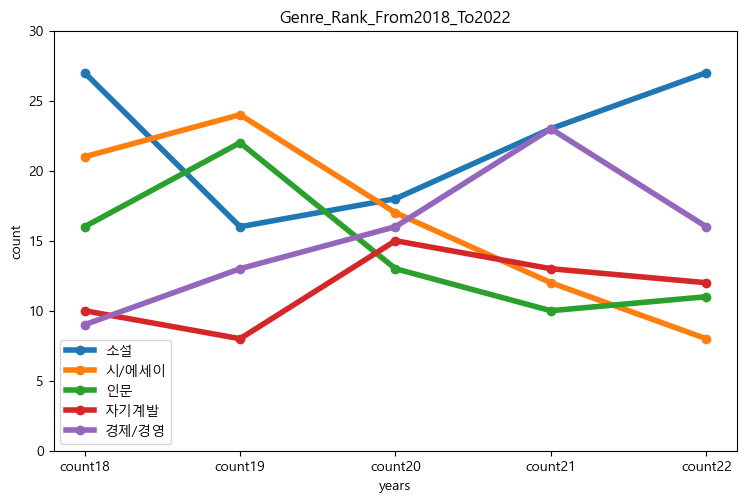

In [6]:
# 상위 5 장르 권 수 결과 확대
fig = plt.figure(figsize=(30,12)) #fig size 조절
fig.set_facecolor('white')
for i in range(len(result)):
    plt.subplot(2,3,6)
    plt.plot(x[1:],y[i][1:],marker='o',label=y[i][0], linewidth='4')

plt.title('Genre_Rank_From2018_To2022')
plt.xlabel('years'); plt.ylabel('count')
plt.legend()
plt.ylim([0,30])
plt.show()

## 분석 3.
### 장르별 코멘트 분포 - 막대그래프로 보기

In [34]:
# 상위 5 장르 당 likes(코멘트) 경향성 막대그래프

sql = """
    SELECT genre, 
        likes, 
        count(likes) AS comment_n 
    FROM best_books_5years
    WHERE years = 2022 
        AND genre in ('소설','시/에세이','인문','자기계발','경제/경영')
    GROUP BY genre, likes 
    ORDER BY genre;
    """

cursor.execute(query=sql)
result = cursor.fetchall() #result

result

[{'genre': '경제/경영', 'likes': '도움돼요', 'comment_n': 1},
 {'genre': '경제/경영', 'likes': '쉬웠어요', 'comment_n': 1},
 {'genre': '경제/경영', 'likes': '집중돼요', 'comment_n': 12},
 {'genre': '경제/경영', 'likes': '추천해요', 'comment_n': 2},
 {'genre': '소설', 'likes': '고마워요', 'comment_n': 19},
 {'genre': '소설', 'likes': '최고예요', 'comment_n': 8},
 {'genre': '시/에세이', 'likes': '고마워요', 'comment_n': 7},
 {'genre': '시/에세이', 'likes': '힐링돼요', 'comment_n': 1},
 {'genre': '인문', 'likes': '도움돼요', 'comment_n': 1},
 {'genre': '인문', 'likes': '집중돼요', 'comment_n': 10},
 {'genre': '자기계발', 'likes': '도움돼요', 'comment_n': 2},
 {'genre': '자기계발', 'likes': '집중돼요', 'comment_n': 10}]

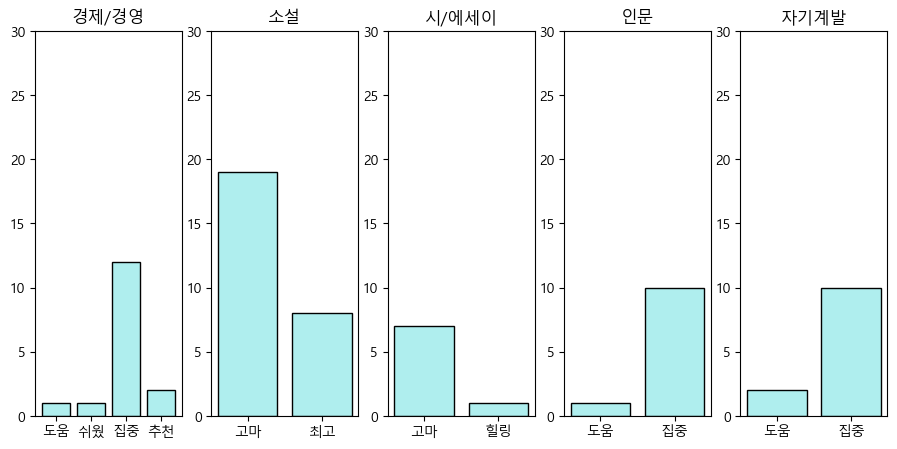

In [61]:
genre_li = ['경제/경영','소설','시/에세이','인문','자기계발']

check = 0
data = [{},{},{},{},{}]

for i in range(len(result)):
    if result[i]['genre'] != genre_li[check]:
        check += 1
        # result의 장르가 해당 인덱스가 아니라면 다음줄로 넘어가세요 
        # (더이상 '경제경영'이 아니라면 '소설' 줄로 넘어가세요)
    data[check][result[i]['likes']] = result[i]['comment_n']

fig = plt.figure(figsize=(11,5))
for i in range(len(data)):
    plt.subplot(1,5,i+1)
    
    x = list(data[i].keys())
    values = list(data[i].values())
    
    plt.bar([x2[:2] for x2 in x], values, color=['paleturquoise'],
           edgecolor = 'black', linewidth = 1)
    plt.title(genre_li[i])
    plt.ylim([0,30])
plt.show()

## 분석 4
### 장당 가격과 베스트 순위 장르별로 묶어보기 - 스캐터 플랏

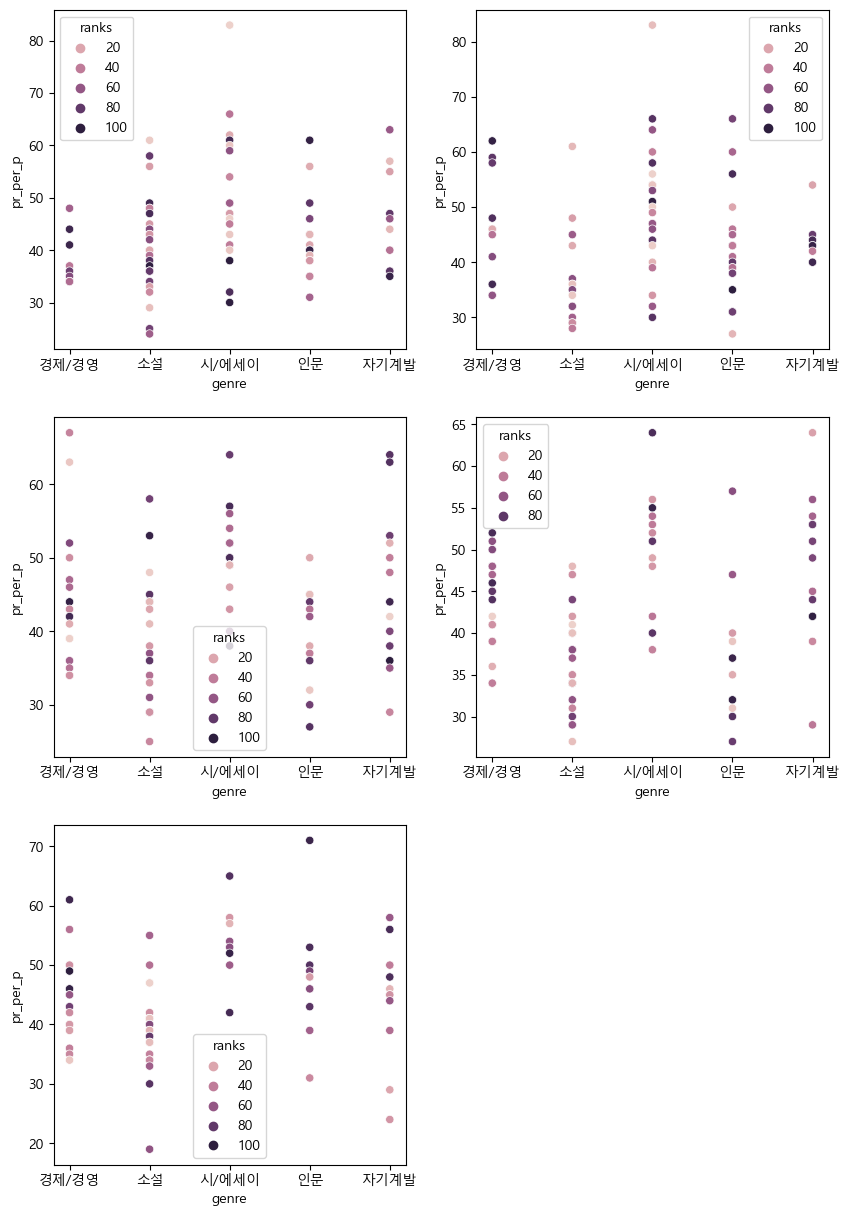

In [71]:
#sql문으로 테이블에 있는 정보 가져오기
db = pymysql.connect(host='localhost', port=3306, user='root', passwd='1234', db='mywork', charset='utf8')
cursor = db.cursor()

fig = plt.figure(figsize=(10,15))
years = [i for i in range(2018,2023)]
for i in range(len(years)):
    
    sql = """
    #장당 가격을 나타내는 서브쿼리
    WITH g_pr_p_r AS (
        SELECT title, 
            publisher, 
            genre, 
            page, 
            price,
            ranks,
            ifnull(round(price/page), 0)  AS pr_per_p
        FROM best_books_5years
        GROUP BY genre, title, publisher, page, ranks, price, pr_per_p
        ORDER BY genre, pr_per_p DESC, page DESC, ranks) 
    SELECT b.genre, 
        a.pr_per_p, 
        a.ranks
    FROM best_books_5years AS b 
    NATURAL JOIN g_pr_p_r AS a
    WHERE b.genre in ('경제/경영','소설','시/에세이','인문','자기계발') 
        AND b.years = {};""".format(years[i])
    cursor.execute(sql)
    test3= cursor.fetchall()

    #판다스로 파이썬에서 테이블화 하기
    pd.set_option('display.max_row', 700)
    table3 = pd.DataFrame(test3, columns = ['genre', 'pr_per_p', 'ranks'])
    
    plt.subplot(3,2,i+1)
    plot3 = sns.scatterplot(data=table3, x='genre', y = 'pr_per_p', hue='ranks')
plt.show()


In [11]:
db.commit()
db.close

<bound method Connection.close of <pymysql.connections.Connection object at 0x000001D1FD2EC490>>